# Image classification with Convolutional Neural Networks: Cats vs Dogs

* [Class Notes](https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-1-602f73869197)
* [Class Video](https://youtu.be/IPBSB1HLNLo)

Use convolutional neural networks (CNNs) to classify images of cats and dogs.

# Preliminaries 

We will create a model to enter the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats) competition at Kaggle. 
There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set to label.  
According to Kaggle, when this competition was launched (end of 2013): *"State of the art: The current literature suggests machine classifiers can score above 80% accuracy on this task"*. 

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does during the course.

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *   # ImageClassifierData
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "/data/dogscats/"

In [5]:
sz=224

#### Extra steps if NOT using Crestle or our scripts

Download the [dataset](http://files.fast.ai/data/dogscats.zip), e.g., by 
```
wget http://files.fast.ai/data/dogscats.zip
```
Put the data in a subdirectory of this notebook's directory, called `data/`.

#### Extra steps if using Crestle

Crestle has the datasets required for fast.ai in /datasets, so we'll create symlinks to the data we want for this competition. (NB: we can't write to /datasets, but we need a place to store temporary files, so we create our own writable directory to put the symlinks in, and we also take advantage of Crestle's `/cache/` faster temporary storage space.)

To run these commands (**which you should only do if using Crestle**) remove the `#` characters from the start of each line.

In [6]:
# os.makedirs('data/dogscats/models', exist_ok=True)
# !ln -s /datasets/fast.ai/dogscats/train {PATH}
# !ln -s /datasets/fast.ai/dogscats/test {PATH}
# !ln -s /datasets/fast.ai/dogscats/valid {PATH}
# os.makedirs('/cache/tmp', exist_ok=True)
# !ln -fs /cache/tmp {PATH}

# First look at cat pictures

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [7]:
!ls {PATH}

models	sample	test1  tmp  train  valid


In [8]:
!ls {PATH}valid

cats  dogs


In [9]:
files = !ls {PATH}valid/cats | head
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

This folder structure is the most common approach for image classification datasets: Each folder name gives the label (e.g. dogs or cats). There is a train folder and valid folder. 
Under each of these, folders with classification labels (e.g. cats and dogs) with corresponding images.
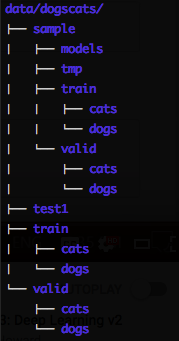

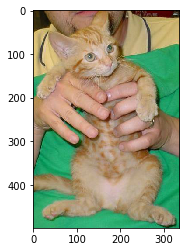

In [10]:
img = plt.imread(f'{PATH}valid/cats/{files[1]}')  # Python 3.6 string format
plt.imshow(img);   # from matplotlib

Here is how the raw data looks like: `img` is a 3 dimensional array (a.k.a. rank 3 tensor). The `shape` indicates that this is a 198x179 pixels image, with 3 color channels.

In [11]:
img.shape

(499, 336, 3)

For example, the first pixel, (e.g. [29, 20, 23]) represents 29 Red 20 Green 23 Blue pixel values (between 0 and 255)

In [12]:
img[:4,:4]

array([[[60, 58, 10],
        [60, 57, 14],
        [61, 56, 18],
        [63, 54, 23]],

       [[56, 54,  6],
        [56, 53, 10],
        [57, 52, 14],
        [60, 51, 20]],

       [[52, 49,  4],
        [52, 49,  6],
        [53, 48, 10],
        [56, 47, 16]],

       [[50, 47,  2],
        [50, 47,  4],
        [51, 45,  9],
        [53, 44, 13]]], dtype=uint8)

We will use these numbers to predict whether the image is a cat or a dog. 
We will learn how to predict by looking at lots of labeled pictures of cats and dogs.

# Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch, we use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. 
The model is a Convolutional Neural Network (CNN), a type of NN that builds state-of-the-art models for computer vision (CV). 

We use the **resnet34** model, a version of a model that won the 2015 ImageNet competition. 
See [resnet models](https://github.com/KaimingHe/deep-residual-networks) for more details. 
Below we train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds:

- `ImageClassifierData.from_paths` creates a `data` object that contains the training and validation data.
- `ConvLearner` creates a learner object `learn` which contains the model, with the given architecture and data
- learn.fit is the actual learning step, here for 3 epochs with a learning rate of 0.01

In [13]:
# Uncomment the below if you need to reset your precomputed activations
#!rm -rf {PATH}tmp

In [14]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz)) # dataset.py
learn = ConvLearner.pretrained(arch, data, precompute=True)
%time learn.fit(0.01, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.045488   0.030161   0.9885    
    1      0.039853   0.027699   0.989                        
    2      0.041698   0.026514   0.991                        

CPU times: user 17.6 s, sys: 9.3 s, total: 26.9 s
Wall time: 19.3 s


[array([0.02651]), 0.991]

- `epoch` is the epoch number. It run for 3 epochs, ie looked at the entire set of images 3 times.
- `accuracy` is the accuracy on the validation set.
- `trn_loss` is the cross-entropy loss for the training set 
- `val_loss` is the cross-entropy loss and the validation set.

How good is this model? Prior to this competition, the state of the art was 80% accuracy. 
But the competition resulted in a huge jump to 98.9% accuracy, with the author of a popular deep learning library winning the competition. 
Now (2017) we beat that result in 18 seconds.
In 2016, the initial model had 98.3% accuracy, ie nearly double the error we're getting now,
and it took $\approx$ 10 minutes to compute.

# Analyzing results: looking at pictures

Lets look at examples of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [15]:
# This is the label for a val data ("the correct" answers)
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [16]:
# Note that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['cats', 'dogs']

In [17]:
# this gives prediction for the validation set. Predictions are in log scale, for both classes
log_preds = learn.predict()
log_preds.shape

(2000, 2)

The output is pairs of predictions (in log scale) for cats and dogs.

In [18]:
log_preds[:10]

array([[ -0.00006,  -9.67109],
       [ -0.00048,  -7.63984],
       [ -0.00002, -10.98648],
       [ -0.00005,  -9.89384],
       [ -0.00007,  -9.5573 ],
       [ -0.00001, -11.25829],
       [ -0.00193,  -6.25058],
       [ -0.00001, -11.24325],
       [ -0.00006,  -9.66949],
       [ -0.00001, -11.4285 ]], dtype=float32)

In [19]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

To get the probabilities we use `np.exp`

Below we use numpy functions to get specific images.

- `np.random.choice()` Generates a random sample of size (eg 4) from a given 1-D array. (a, size=None, replace=True, p=None)¶

- `np.where(condition[, x, y])`    Return elements, either from x or y, depending on condition.
    If only condition is given, return condition.nonzero().

In [20]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [21]:
def plot_val_with_title(idxs, title):
    imgs = np.array([data.val_ds[x][0] for x in idxs])   # was np.stack()
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [22]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [23]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


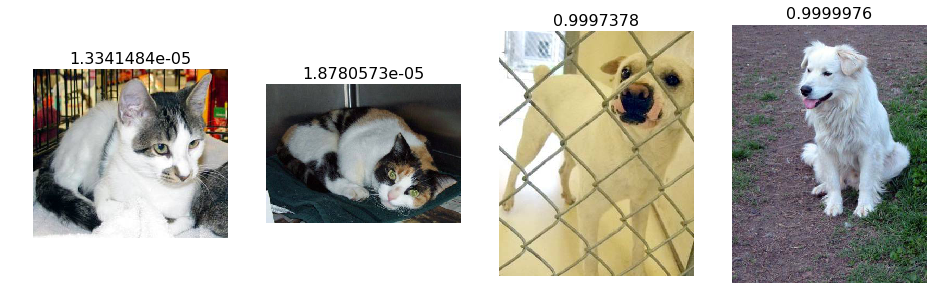

In [24]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


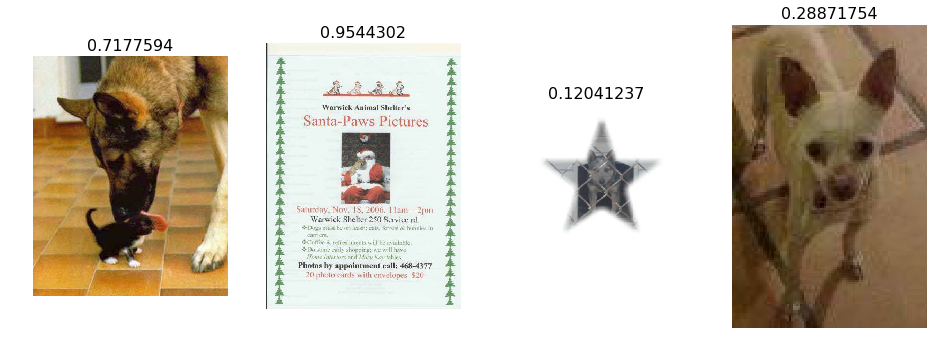

In [25]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [26]:
def most_by_mask(mask, mult):   
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): # y=0 for cats, y=1 for dogs
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


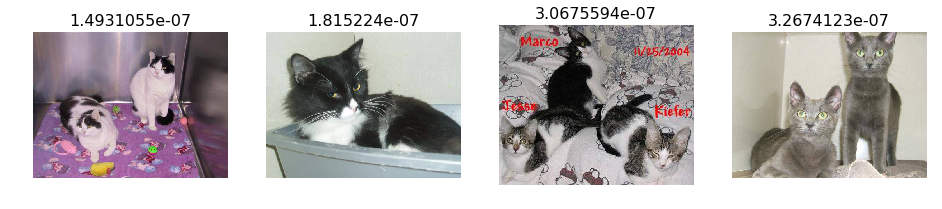

In [27]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


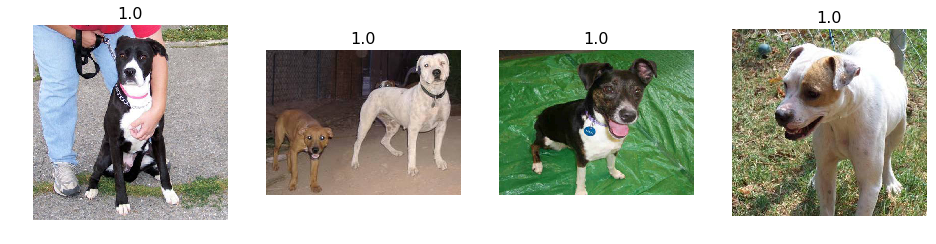

In [28]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Now what the model thought it was definitely a dog but turns out to be a cat...

Most incorrect cats


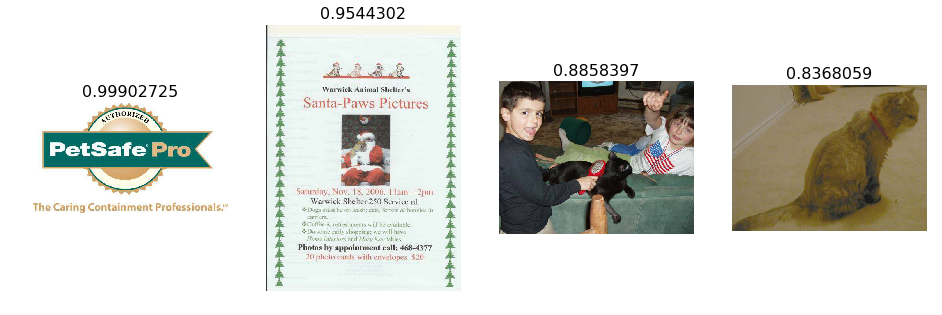

In [29]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

And vice-versa

Most incorrect dogs


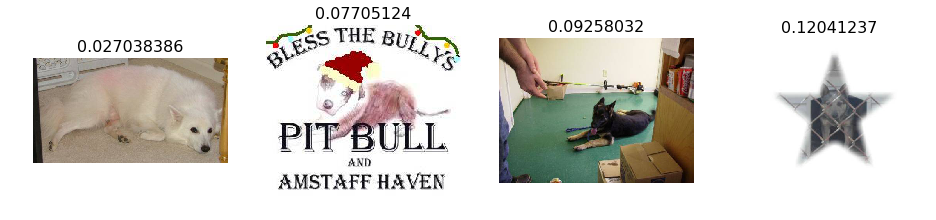

In [30]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Here the most uncertain...

Most uncertain predictions


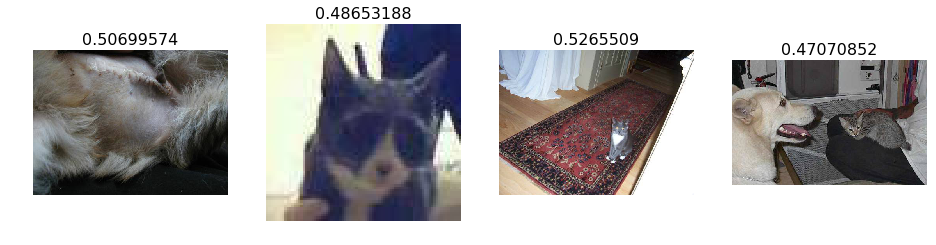

In [31]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

It is important to visualize what the model does, in order to improve it, 
take advantage of what it does well and fix what is doing badly.
Also, we learned something about the dataset itself: There are some images that should not be in it. 
And the model can improve (e.g. data augmentation). 

TODO: Build your own image classifier (for **regular photos**, ie similar to Imagenet, not CT scans, etc.) 
An example [Baseball or Cricket? USD or CAN?](https://towardsdatascience.com/fun-with-small-image-data-sets-8c83d95d0159)

[Forum post](http://forums.fast.ai/t/understanding-softmax-probabilities-output-on-a-multi-class-classification-problem/8194/13) for different way of visualizing the results (e.g. when there are more than 2 categories, etc)

# Choosing a learning rate

The *learning rate* determines how quickly/slowly to update the *weights* (or *parameters*). 
Learning rate significantly affect model performance.<br>
The method `learn.lr_find()` helps you find an optimal learning rate. 
It uses the technique from [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186).  It increases the learning rate from a very small value, until the loss starts increasing. 

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [32]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [33]:
lrf=learn.lr_find()   # fastai/learner.py

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 85%|████████▌ | 306/360 [00:05<00:00, 59.64it/s, loss=0.437]


The `learn` object contains an attribute `sched` that contains our learning rate scheduler, 
and plotting functionality including this one:
`learn.sched.plot_lr()` can plot the learning rate across batches to see what this looks like.

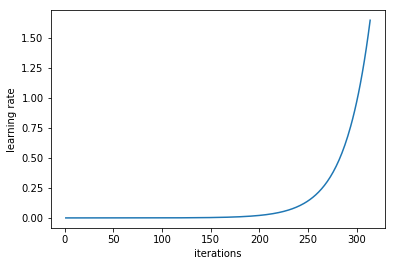

In [34]:
learn.sched.plot_lr()

Note that in the plot *iteration* is one *minibatch* of SGD. 
In one epoch (going thru the whole data once), there are  $(num\_train\_samples/num\_iterations)$ of SGD.
So if we had 25000 training samples, and each epoch as 360 iterations, for about 70 images, 
each of size sz (224) ?
**TODO: Validate sizes** <br>
We can see the plot of loss versus learning rate to see where our loss stops decreasing:

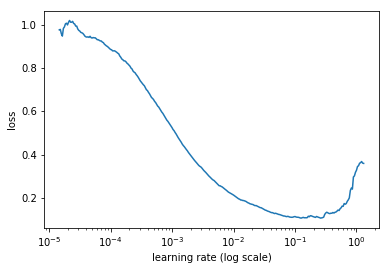

In [35]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use.<br>
Note that the optimal learning rate can change as we training the model, 
so we may want to re-run this function from time to time.

# Improving our model

## Data augmentation

If we train for more epochs, we start to *overfit*: the model is learning to recognize the specific images in the training set, rather than generalizing.
One way to fix this is to create more data, through *data augmentation*, i.e,
randomly changing the images in ways that shouldn't impact their interpretation, 
such as horizontal flipping, zooming, and rotating.

We do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, 
with a list of functions to apply that change the image. 
For photos that are largely taken from the side (most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. 
We can also specify random zooming of images up to a specified scale by adding the `max_zoom` parameter.

Initially, the augmentations actually do nothing because of precompute=True.

In [36]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [37]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [38]:
ims = np.stack([get_augs() for i in range(6)])

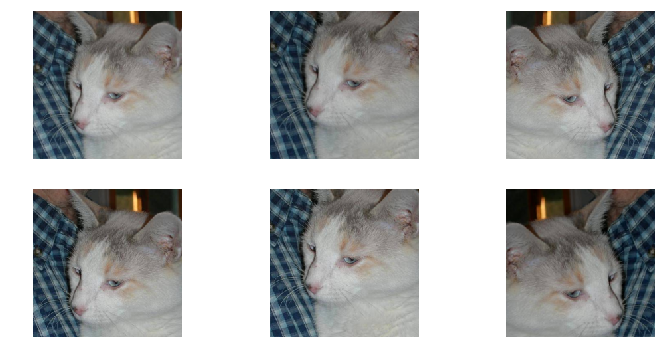

In [39]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [40]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [41]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.05052    0.030769   0.99      



[array([0.03077]), 0.99]

In [42]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [43]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.049796   0.028366   0.991     
    1      0.042598   0.027735   0.9895                       
    2      0.048365   0.028196   0.99                         



[array([0.0282]), 0.99]

Bad news is that accuracy is not improving. 
Training loss is decreasing but validation loss is not, but we are not overfitting. 
Overfitting is when the training loss is much lower than the validation loss. 
The model is doing much better on the training set than on the validation set, i.e., the model is not generalizing.

What is that `cycle_len` parameter? 
What we've done here is used a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. 
This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. 
We want to encourage our model to find parts of the weight space that are both accurate and stable. 
Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". 

`cycle_len` is the number of epochs between resetting the learning rate. 
The number of times this happens is the *number of cycles*, the 2nd parameter to `fit()`, e.g. 3 below. 
```
learn.fit(1e-2, 3, cycle_len=1)
```
So here's what our actual learning rates looked like at each iteration:

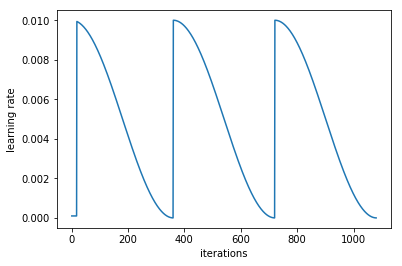

In [44]:
learn.sched.plot_lr()

Our validation loss isn't improving much, so there's no point further training the last layer on its own.

Since we now have got a good model, we save it so we can load it again later without training it from scratch.

In [45]:
learn.save('224_lastlayer')

In [46]:
learn.load('224_lastlayer')

## Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. 
`unfreeze()` tells the learner to unfreeze the remaining layers.

In [47]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize Imagenet photos (whereas our final layers where randomly initialized), so we want to avoid destroying the carefully tuned weights already there.<br>

As the earlier layers have more general-purpose features, we expect them to need less fine-tuning for new datasets. 
For this reason we use different [**discriminative learning rates**](https://arxiv.org/pdf/1801.06146.pdf) for different layers: 
- the first few layers will be at $1e^{-4}$, 
- the middle layers at $1e^{-3}$, and
- FC layers at $1e^{-2}$ as before. 

In [48]:
lr=np.array([1e-4,1e-3,1e-2])

In [49]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.053319   0.027133   0.9885    
    1      0.040457   0.027931   0.9895                       
    2      0.036284   0.020266   0.991                        
    3      0.029086   0.019045   0.9915                       
    4      0.022024   0.021125   0.992                        
    5      0.020667   0.019212   0.9925                       
    6      0.020465   0.018623   0.992                        



[array([0.01862]), 0.992]

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart. 
What is `cycle_mult` doing? <br>
`cycle_mult=2`: multiplies the length of the cycle after each cycle (1 epoch + 2 epochs + 4 epochs = 7 epochs).
[53:57], if the cycle length is too short, it starts going down to find a good spot, then pops out, and goes down trying to find a good spot and pops out, and never actually get to find a good spot. 
Earlier on, you want it to do that because it is trying to find a spot that is smoother, but later on, you want it to do more exploring. 
That is why cycle_mult=2 seems to be a good approach.

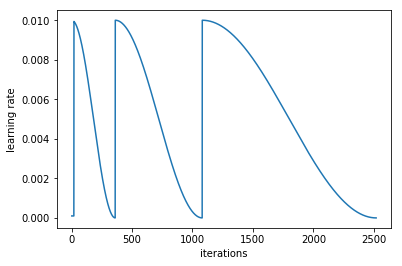

In [50]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [51]:
learn.save('224_all')

In [52]:
learn.load('224_all')

### Test Time Augmentation (TTA)
 
We can also do data augmentation at *inference* time (also known as *test* time).<br>
TTA makes predictions on the images in the validation set, **and** *makes predictions on a number of randomly augmented versions of them*. Bby default, it uses the original image along with 4 randomly augmented versions. 
It then takes the average prediction from these images, and uses that. 
To use TTA on the validation set, we use the learner's `TTA()` method.

In [53]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [54]:
accuracy_np(probs, y)   #was just accuracy and failed...

0.994

JH usually sees about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

## Analyzing results

### Confusion matrix 

In [55]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [56]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[994   6]
 [  6 994]]


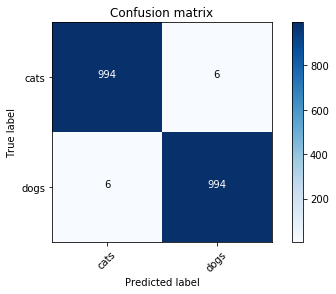

In [57]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

Most incorrect cats


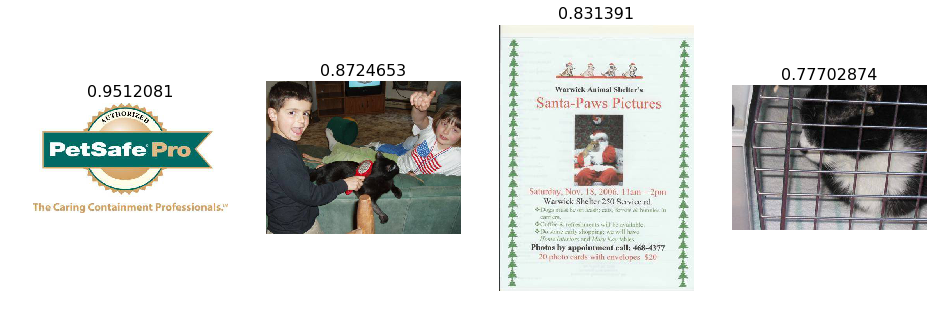

In [58]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


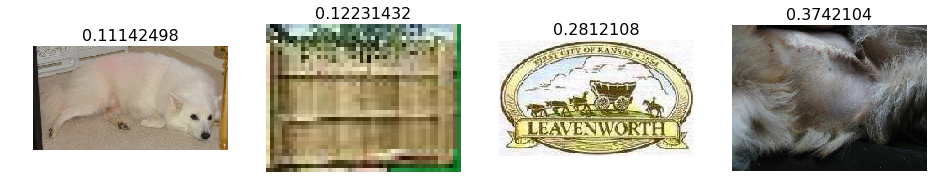

In [59]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

When we do the validation set, all inputs to the model must be square. 
The reason is that GPUs do not go as fast if there are different dimensions for different images. 
It needs to be consistent so that every part of the GPU can do the same thing. 
This may eventually be fixed, but for now that is the state of the technology.<br>
To make it square, we just picked the square in the middle.
See example below to understand why this picture was classified incorrectly:
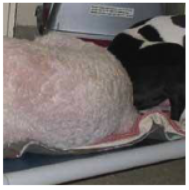

# Review: easy steps to train a world-class image classifier

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## Understanding the code for our first model

Let's look at the Dogs v Cats code line by line.

**tfms** stands for *transformations*. `tfms_from_model` takes care of resizing, image cropping, initial normalization (creating data with (mean,stdev) of (0,1)), and more.

In [60]:
tfms = tfms_from_model(resnet34, sz)

We need a <b>path</b> that points to the dataset. In this path we will also store temporary data and final results. `ImageClassifierData.from_paths` reads data from a provided path and creates a dataset ready for training.

In [61]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

`ConvLearner.pretrained` builds *learner* that contains a pre-trained model. 
The last layer of the model needs to be replaced with the layer of the right dimensions. 
The pretained model was trained for (Imagenet) 1000 classes, so the final layer predicts a vector of 1000 probabilities. 
For cats and dogs we need to output a two dimensional vector. 
The diagram below shows in an example how this was done in one of the earliest successful CNNs. 
The layer "FC8" here would get replaced with a new layer with 2 outputs.

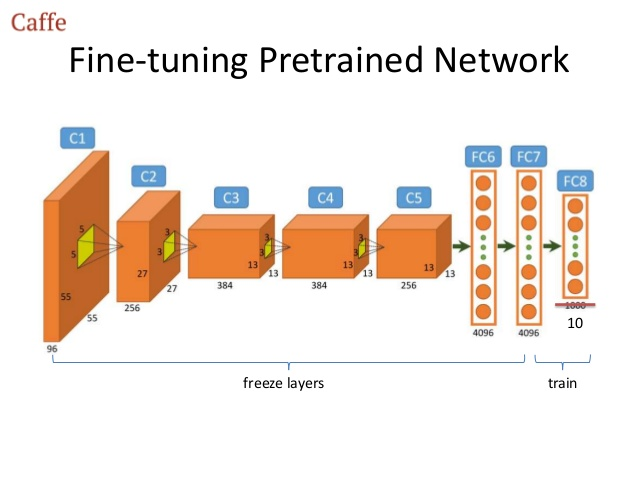

In [62]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

*Parameters*  are learned by fitting a model to the data. 
*Hyperparameters* are another kind of parameter, that cannot be directly learned from the regular training process. These parameters express “higher-level” properties of the model such as its complexity or how fast it should learn. Two examples of hyperparameters are the *learning rate* and the *number of epochs*.

During iterative training of a neural network, a *batch* or *mini-batch* is a subset of training samples used in one iteration of Stochastic Gradient Descent (SGD). 
An *epoch* is a single pass through the entire training set which consists of multiple iterations of SGD.

We can now *fit* the model; that is, use *gradient descent* to find the best parameters for the fully connected layer we added, that can separate cat pictures from dog pictures. 
We need to pass two hyperparameters: 
- the *learning rate* (generally 1e-2 or 1e-3 is a good starting point, we'll look more at this next) and the 
- *number of epochs* (you can pass in a higher number and just stop training when you see it's no longer improving, then re-run it with the number of epochs you found works well.)

In [63]:
learn.fit(1e-2, 1, wds=None)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.0496     0.024765   0.99      



[array([0.02476]), 0.99]

# END - REFERENCES

- [Lesson 1 Notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb)
- [Hiromi Suenaga Class notes](https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-1-602f73869197)
- [Hiromi Suenaga Class notes](https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-2-eeae2edd2be4)